In [16]:
# @Chapter
# 자전거 수요 예측[3/4] 캐글 머신러닝 랜덤포레스트만으로 경진대회에 참여하기
# https://www.youtube.com/watch?v=g7EwIFXJntc&t=179s

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# I can draw graph inline with this
%matplotlib inline

# I can fix the issue of broken "-" in the graph with this
mpl.rcParams['axes.unicode_minus'] = False
    
import warnings
warnings.filterwarnings('ignore')

In [12]:
# load train data and test data file
train = pd.read_csv("D://chromedown//kaggle - bike//train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [13]:
test = pd.read_csv("D://chromedown//kaggle - bike//test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [15]:
# I want to process feature engineering
# I loaded train data and test data as datetime type
# I want to make them detailed data type
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [17]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

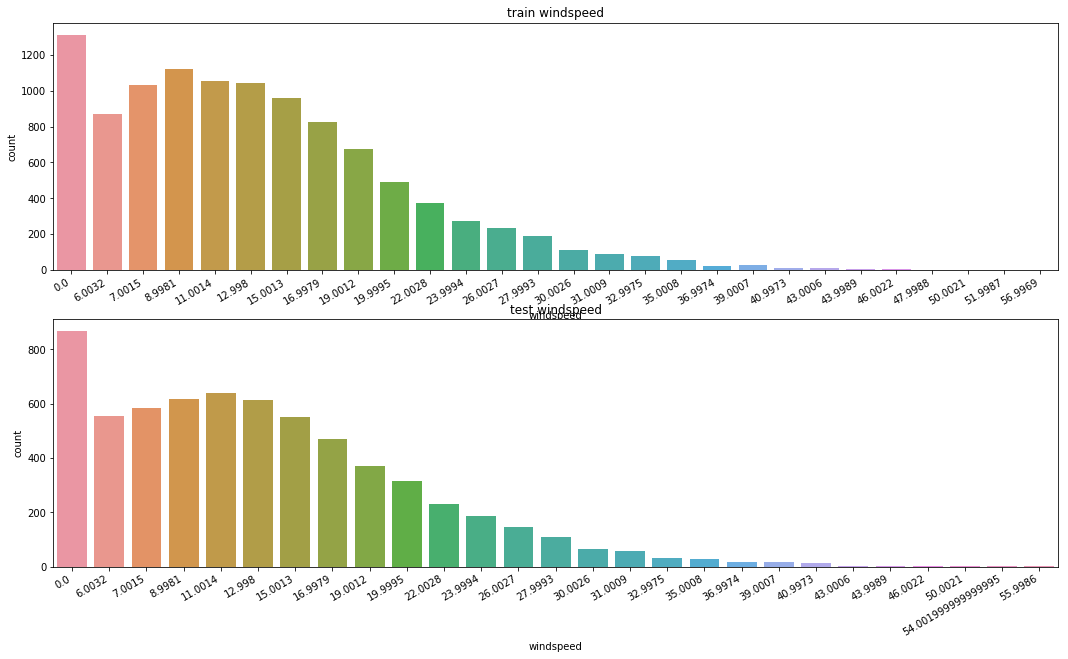

In [19]:
# I visualize data
# I can see there are a lot of data on windspeed 0
# It might come from a bad measurement so I need to refine them
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)
plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [22]:
# I separate data into windspeed 0 and windspeed not 0 in train data
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
# I can see windspeed not 0 is much more many than windspeed 0
trainWind0.shape

(1313, 19)

In [24]:
trainWindNot0.shape

(9573, 19)

In [25]:
from sklearn.ensemble import RandomForestClassifier
def predict_windspeed(data):
    
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # I select features for expecting windspeed model
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # I change data type of windspeed not 0 data to the string to use
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # I will use random forest classifier
    rfModel_wind = RandomForestClassifier()

    # I'm making a expecting model for the windspeed
    # And the training data for this expecting model is data composed of wCol
    # I want to find optimized parameters(letting an expecting model for the windspeed to learn) for this expecting model
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # Let the expecting model to expect the windspeed
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # New data holders
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # datatype of windspeed as float
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [27]:
# I use predict_windspeed() with putting train data to refine windspeed 0 data
train = predict_windspeed(train)
# test = predict_windspeed(test)

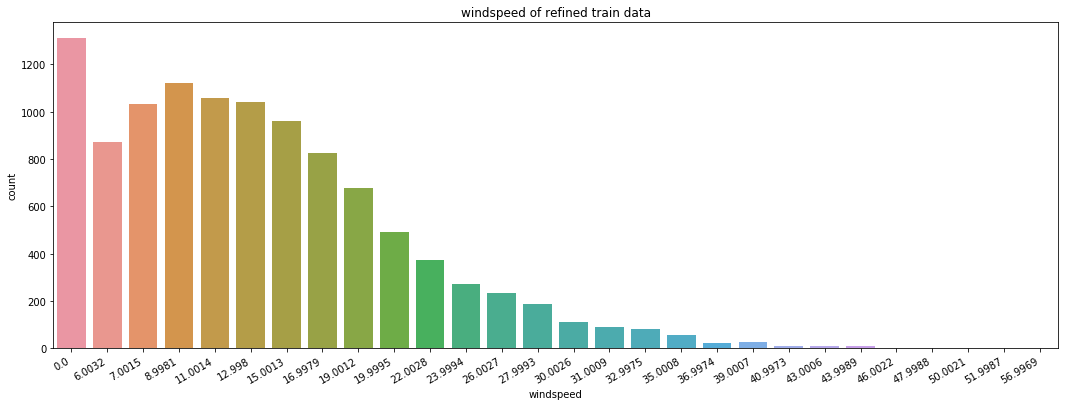

In [26]:
# I visualize refined data
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
# data label text on x axis is rotated by 30 degree
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title="windspeed of refined train data")
sns.countplot(data=train, x="windspeed", ax=ax1)
# I can confirm windspeed 0 data eleminated

In [29]:
# I need to process "feature selection"
# 1. It's required to distinguish between meaningful data and noise
# 1. It doesn't mean the more feature, the better performance
# 1. It's recommended to add feature one by one with testing the performance and eliminate that feature if it turned out it's not that helpful feature
# continuous feature and categorical feature 
# continuous feature = ["temp","humidity","windspeed","atemp"]

# I choose following features as categorical feature
categorical_feature_names = ["season", "holiday", "workingday", "weather", "dayofweek", "month", "year", "hour"]
# categorical feature is needed to be a categorical data type
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [28]:
# They show entire features
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed", "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [30]:
# I create a new matrix X_train after pre processing above
X_train = train[feature_names]
X_train.shape

(10886, 11)

In [31]:
X_train.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [32]:
# I create a new matrix X_test after pre processing above
X_test = test[feature_names]
X_test.shape

(6493, 11)

In [33]:
X_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [34]:
# I use "count" feature as y data
label_name = "count"
y_train = train[label_name]
y_train.shape

(10886,)

In [35]:
y_train.head()

0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [40]:
# "bike sharing contest" is evaluated by RMSLE

# I implement RMSLE algorithm in rmsle()
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # I will use data as numpy array
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # I should implement this formular
    # $\sqrt{\frac{1}{n} \sum\limits_{i=1}^{n}(\log{(p_{i}+1)}-\log{(a_{i}+1)})^{2}}$
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

In [42]:
rmsle_scorer = make_scorer(rmsle)

In [43]:
# I will use KFold for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# I will expect by random forest
from sklearn.ensemble import RandomForestRegressor
max_depth_list = []
# n_estimators higher makes better precision but consuming more time to expect
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [47]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# It's better data, the closer to 0
"Score= {0:.5f}".format(score)

Wall time: 10.5 s


'Score= 0.33109'

In [48]:
# I make it learn by inputting feature(X_train), label(the answer, y_train)
model.fit(X_train, y_train)

# I make it predict based on learnt model by inputting X_test
predictions = model.predict(X_test)

predictions.shape

(6493,)

In [49]:
predictions[0:10]

array([ 12.2 ,   4.87,   4.19,   3.47,   3.03,   6.28,  38.1 , 105.49,
       235.54, 136.4 ])

[Text(0.5,1,'predicted y value from test data of multiple x values')]

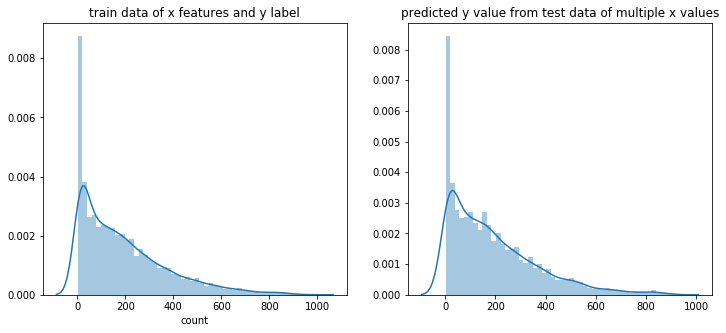

In [50]:
# I visualize predicted data
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train data of x features and y label")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="predicted y value from test data of multiple x values")
# I can see similar distribution of data between two of them

In [52]:
# I will submit this code
# For that, I need to input predicted values into sampleSubmission.csv file
# First, I load that file
submission = pd.read_csv("D://chromedown//kaggle - bike//sampleSubmission.csv")
# I input predictions into submission's count column
submission["count"] = predictions
submission.shape

(6493, 2)

In [53]:
print(submission.head())

              datetime  count
0  2011-01-20 00:00:00  12.20
1  2011-01-20 01:00:00   4.87
2  2011-01-20 02:00:00   4.19
3  2011-01-20 03:00:00   3.47
4  2011-01-20 04:00:00   3.03


In [54]:
# I create a file storing score in the contents and file name
submission.to_csv("D://chromedown//kaggle - bike//Score_{0:.5f}_submission.csv".format(score), index=False)